In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as pylab
from datetime import datetime
import os
import sys
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller

import astropy.stats as ast_stats

import pyflux as pf

import traces

import warnings
warnings.filterwarnings('ignore')
import tqdm

from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

from sklearn.model_selection import TimeSeriesSplit

from scipy import integrate

from numpy import array, arange, abs as np_abs
from numpy.fft import rfft, rfftfreq

import stldecompose

from sklearn.manifold import TSNE,MDS

from sklearn.ensemble import RandomForestRegressor

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def plotly_df(df, title = ''):
    data = []
    column = 'cpu'
    trace = go.Scatter(
        x = df.index,
        y = df.values,
        mode = 'lines',
        name = column
    )
    data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [3]:
def load_files_from_folder(files_name, col_name, root):
    datas = []
    for file in os.listdir(root):
        if os.path.isdir(os.path.join(root, file)):
            ip = file
            for fl in os.listdir(os.path.join(root, file)):
                cols = ['timestamp', col_name]
                if files_name in fl:
                    df = pd.read_csv(
                        os.path.join(root,file,fl),
                        sep=',',
                        encoding='utf-8',
                        dtype='str',
                        names=cols
                    )
                    df['ip'] = ip
                    datas.append(df)
    return pd.concat(datas, ignore_index=True, axis=0)

In [4]:
def split_date_and_set_week(df, col_name):
    mapping = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
    weeknum_mapping = {
        range(1,8):'0',
        range(8,15):'1',
        range(15,22):'2',
        range(22,29):'3',
        range(29,33):'4'
    }
    
    def set_weeknum(day):
        for k,v in weeknum_mapping.items():
            if day in k:
                return v
    
    df.timestamp = df.timestamp.astype(int)
    df['date'] = df.timestamp.apply(lambda x: datetime.fromtimestamp(x/1000000))
    df['year'] = df.date.apply(lambda x: x.year)
    df['month'] = df.date.apply(lambda x: x.month)
    df['day'] = df.date.apply(lambda x: x.day)
    df['hour'] = df.date.apply(lambda x: x.hour)
    df['minute'] = df.date.apply(lambda x: x.minute)
    df['second'] = df.date.apply(lambda x: x.second)
    df['weekday'] = df.date.apply(lambda x: mapping[x.weekday()])
    df['weeknum'] = df.day.apply(set_weeknum)
    df['weekend'] = df.weekday.apply(lambda x: 1 if x == 'sat' or x == 'sun' else 0)
    df['busy'] = df.hour.apply(lambda x: 1 if 9<=x<18 else 0)
    try:
        df[col_name] = df[col_name].astype(int)
    except:
        df[col_name] = df[col_name].astype(float)
    return df

In [5]:
def select_data(files_name, col_name, root='./../../Downloads/ciscoSwitch/attributes/'):
    df = load_files_from_folder(files_name=files_name, col_name=col_name, root=root)
    df = split_date_and_set_week(df, col_name)
    return df

In [6]:
df = select_data('cpuUtil', 'cpu')

In [ ]:
df.head(2)

In [ ]:
# df_mem = select_data('memUtil', 'mem')

In [ ]:
df_mem.head(2)

In [7]:
df_in = select_data('inUtil', 'in', './../../Downloads/ciscoSwitch/interfacesSamples/')

In [ ]:
df_in.head(2)

In [ ]:
df_out = select_data('outUtil', 'out', './../../Downloads/ciscoSwitch/interfacesSamples/')

In [ ]:
df_out.head(2)

In [ ]:
intersect_ip = list( 
                    set(df['ip'].unique()) & 
                    set(df_mem['ip'].unique()) &  
                    set(df_out['ip'].unique()) & 
                    set(df_in['ip'].unique()) 
                   )

## Wavelet

In [11]:
df_in.head()

,timestamp,in,ip,date,year,month,day,hour,minute,second,weekday,weeknum,weekend,busy
0,1506805302848497,3.37,10.10.245.12,2017-10-01 00:01:42.848497,2017,10,1,0,1,42,sun,0,1,0
1,1506805604560347,2.98,10.10.245.12,2017-10-01 00:06:44.560347,2017,10,1,0,6,44,sun,0,1,0
2,1506805902877354,3.06,10.10.245.12,2017-10-01 00:11:42.877354,2017,10,1,0,11,42,sun,0,1,0
3,1506806208656659,2.93,10.10.245.12,2017-10-01 00:16:48.656659,2017,10,1,0,16,48,sun,0,1,0
4,1506806502909640,2.77,10.10.245.12,2017-10-01 00:21:42.909640,2017,10,1,0,21,42,sun,0,1,0


In [9]:
df_in.ip.unique()[:3]

array(['10.10.245.12', '10.10.246.8', '10.21.7.42'], dtype=object)

In [14]:
t = df_in[df_in.ip == df_in.ip.unique()[0]][['timestamp', 'in']]

In [16]:
t['in'].head()

0    3.37
1    2.98
2    3.06
3    2.93
4    2.77
Name: in, dtype: float64

### Сколько ip мы вообще не будем рассматривать?

In [ ]:
print(df['ip'].unique().shape[0] - len(intersect_ip))
print(df_mem['ip'].unique().shape[0] - len(intersect_ip))
print(df_out['ip'].unique().shape[0] - len(intersect_ip))
print(df_in['ip'].unique().shape[0] - len(intersect_ip))

In [ ]:
df = df[df.ip.isin(intersect_ip)]
df_mem = df_mem[df_mem.ip.isin(intersect_ip)]
df_out = df_out[df_out.ip.isin(intersect_ip)]
df_in = df_in[df_in.ip.isin(intersect_ip)]

In [ ]:
def get_unique_stat(df, col_name):
    ip = []
    n = []
    nunique = []
    for k,v in df.groupby(['ip']):
        ip.append(k)
        n.append(v['timestamp'].count())
        nunique.append(v[col_name].unique().shape[0])

    unique_stat = pd.DataFrame()
    unique_stat['ip'] = ip
    unique_stat['n'] = n
    unique_stat['nunique'] = nunique
    unique_stat['ratio'] = unique_stat['nunique']/unique_stat['n']
    return unique_stat

In [ ]:
un_cpu = get_unique_stat(df, 'cpu')

In [ ]:
un_mem = get_unique_stat(df_mem, 'mem')

In [ ]:
un_in = get_unique_stat(df_in, 'in')

In [ ]:
un_out = get_unique_stat(df_out, 'out')

In [ ]:
un_cpu.head()

In [ ]:
un_mem.head()

In [ ]:
un_in.head()

In [ ]:
un_out.head()

In [ ]:
f = plt.figure(figsize=(17,8))
pylab.subplot(4,2,1)
sns.distplot(un_cpu['n'])
pylab.subplot(4,2,2)
sns.distplot(un_cpu['nunique'])

pylab.subplot(4,2,3)
sns.distplot(un_mem['n'])
pylab.subplot(4,2,4)
sns.distplot(un_mem['nunique'])

pylab.subplot(4,2,5)
sns.distplot(un_in['n'])
pylab.subplot(4,2,6)
sns.distplot(un_in['nunique'])

pylab.subplot(4,2,7)
sns.distplot(un_out['n'])
pylab.subplot(4,2,8)
sns.distplot(un_out['nunique'])

f.savefig('./../Desktop/multi_distr.png')

In [ ]:
def plot_valid_invalid(un, is_mem=False):
    print(un['nunique'].median())
    print(un['nunique'].mean())
    print()
    print(un['n'].median())
    print(un['n'].mean())

    if is_mem:
            clazz = (un['n'] >= un['n'].quantile(.01)) & \
            (un['nunique'] >= un['nunique'].quantile(.01)) & \
            (un['n'] <= un['n'].quantile(.99)) & \
            (un['nunique'] <= un['nunique'].quantile(.99))
    else:    
        clazz = (un['n'] >= un['n'].quantile(.25)) & \
                (un['nunique'] >= un['nunique'].quantile(.25)) & \
                (un['n'] <= un['n'].quantile(.75)) & \
                (un['nunique'] <= un['nunique'].quantile(.75))
    unn = un.copy(deep=True)
    unn['class'] = clazz.astype(int).values

    sns.lmplot(data=unn, x='n', y='nunique', hue='class', size=8, aspect=2, legend=False, scatter=True, logistic=False)
    plt.xlabel(u'Количество измерений')
    plt.ylabel(u'Количество уникальных значений в измерениях')
    plt.axvline(un['n'].quantile(.25), color='g', linestyle='--', label='n quantile(.25)')
    plt.axvline(un['n'].quantile(.75), color='g', linestyle='--', label='n quantile(.75)')
    plt.axhline(un['nunique'].quantile(.25), color='r', linestyle='--', label='nunique quantile(.25)')
    plt.axhline(un['nunique'].quantile(.75), color='r', linestyle='--', label='nunique quantile(.75)')
    plt.legend()
    
    return unn

In [ ]:
unn_cpu = plot_valid_invalid(un_cpu)

In [ ]:
unn_mem = plot_valid_invalid(un_mem, True)

In [ ]:
unn_in = plot_valid_invalid(un_in)

In [ ]:
unn_out = plot_valid_invalid(un_out)

In [ ]:
valid_ip_cpu = unn_cpu.loc[unn_cpu['class']==1, 'ip']
invalid_ip_cpu = unn_cpu.loc[unn_cpu['class']!=1, 'ip']

valid_ip_mem = unn_cpu.loc[unn_mem['class']==1, 'ip']
invalid_ip_mem = unn_cpu.loc[unn_mem['class']!=1, 'ip']

valid_ip_in = unn_in.loc[unn_in['class']==1, 'ip']
invalid_ip_in = unn_in.loc[unn_in['class']!=1, 'ip']

valid_ip_out = unn_out.loc[unn_out['class']==1, 'ip']
invalid_ip_out = unn_out.loc[unn_out['class']!=1, 'ip']

In [ ]:
valid_ips = list(
    set(valid_ip_cpu.unique()) & 
    set(valid_ip_mem.unique()) #& 
    #set(valid_ip_in.unique()) &
    #set(valid_ip_out.unique())
)

invalid_ips = list(
    set(invalid_ip_cpu.unique()) & 
    set(invalid_ip_mem.unique()) #& 
    #set(invalid_ip_in.unique()) &
    #set(invalid_ip_out.unique())
)

In [ ]:
len(valid_ips)

In [ ]:
df = df[df['ip'].isin(valid_ips)]
df_mem = df_mem[df_mem['ip'].isin(valid_ips)]
df_in = df_in[df_in['ip'].isin(valid_ips)]
df_out = df_out[df_out['ip'].isin(valid_ips)]

### Попробуем нагенерить фич и снизить размерность. Мб что в кластеры и свернется

In [ ]:
def get_freq(v, col, freq):
    try:
        frequency, power = ast_stats.LombScargle(v['timestamp'][:24*2].astype(int), v[col][:24*2]).autopower()
        frequency = np.sort(frequency)
        return frequency[-freq]
    except:
        return 0
    
def get_amp(v, col, freq):
    try:
        frequency, power = ast_stats.LombScargle(v['timestamp'][:24*2].astype(int), v[col][:24*2]).autopower()
        power = np.sort(power)
        return power[-freq]
    except:
        return 0
    
def get_weeked_day_high(vv,col):
    mapping = {'sat':5, 'sun':6, 'mon':0, 'tue':1, 'wed':2, 'thu':3, 'fri':4}
    rev_map = {v:k for k,v in mapping.items()}
    
    mask = vv[col] > vv[col].quantile(0.75)
    try:
        return rev_map[np.argmax(np.bincount(vv.loc[mask, 'weekday'].map(mapping)))]
    except:
        return 'no_day'

def set_moda(v: pd.Series):
    try:
        return np.argmax(np.bincount(v))
    except:
        vals = v.unique()
        m = None
        i = None
        for val in vals:
            s = (vals == val).sum()
            if i is None:
                m = s
                i = val
            else:
                if s > m:
                    m = s
                    i = val
        return i
            
    
    
def get_weeked_day_low(vv, col):
    mapping = {'sat':5, 'sun':6, 'mon':0, 'tue':1, 'wed':2, 'thu':3, 'fri':4}
    rev_map = {v:k for k,v in mapping.items()}
    
    mask = vv[col] < vv[col].quantile(0.25)
    try:
        return rev_map[np.argmax(np.bincount(vv.loc[mask, 'weekday'].map(mapping)))]
    except:
        return 'no_day'
    
def ftrs_engine(df, preffix):
    ips = []
    for ip, i in df.groupby('ip'):
        ips.append(ip)
    clust_data = pd.DataFrame()
    clust_data['{}_week_day_high'.format(preffix)] = df.groupby('ip').apply(lambda v: get_weeked_day_high(v,preffix))
    clust_data['{}_week_day_low'.format(preffix)] = df.groupby('ip').apply(lambda v: get_weeked_day_low(v, preffix))

    clust_data['{}_mean'.format(preffix)] = df.groupby('ip')[[preffix]].mean()
    clust_data['{}_median'.format(preffix)] = df.groupby('ip')[[preffix]].median()
    clust_data['{}_std'.format(preffix)] = df.groupby('ip')[[preffix]].std()
    clust_data['{}_moda'.format(preffix)] = df.groupby('ip').apply(lambda v: set_moda(v[preffix]))
    clust_data['{}_q25'.format(preffix)] = df.groupby('ip').apply(lambda v: v[preffix].quantile(.25))
    clust_data['{}_q75'.format(preffix)] = df.groupby('ip').apply(lambda v: v[preffix].quantile(.75))
    clust_data['{}_min'.format(preffix)] = df.groupby('ip')[[preffix]].min()
    clust_data['{}_max'.format(preffix)] = df.groupby('ip')[[preffix]].max()
    clust_data['{}_integ'.format(preffix)] = df.groupby('ip').apply(lambda v: integrate.simps(y=v[preffix].values)/v[preffix].count())
    for lag in range(1,10):
        clust_data['{}_lag{}'.format(preffix,lag)] = df.groupby('ip').apply(lambda v: v[preffix].autocorr(lag=lag))

    clust_data['{}_ratio'.format(preffix)] = df.groupby('ip').apply(lambda v: v[preffix].count()/df[preffix].count())
    
    clust_data['{}_unique'.format(preffix)] = df.groupby('ip').apply(lambda x: x[preffix].unique().shape[0])


#     for freq in range(1,5):
#         clust_data['{}_freq{}'.format(preffix,freq)] = cpu.groupby('ip').apply(lambda v: get_freq(v, preffix, freq))
#         clust_data['{}_freq{}_amp{}'.format(preffix,freq, freq)] = cpu.groupby('ip').apply(lambda v: get_amp(v, preffix, freq))
    return clust_data, ips

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
def prepare_data_for_clustering(df, col):
    from sklearn.preprocessing import MinMaxScaler
    sclr = MinMaxScaler(feature_range=(0,1))
    cpu_clust, ips = ftrs_engine(df, col)
    tt = pd.get_dummies(cpu_clust.select_dtypes(include='object'))
    cpu_clust = pd.concat([cpu_clust, tt],axis=1)
    cpu_clust.drop(cpu_clust.select_dtypes(include='object').columns.tolist(),axis=1,inplace=True)
    
    cpu_clust.fillna(10, inplace=True)
    
    prepared = sclr.fit_transform(cpu_clust)
    for i, col in enumerate(cpu_clust.columns):
        cpu_clust[col] = prepared[:,i]

    corr = cpu_clust.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(20,10))
    sns.heatmap(corr, annot=False, cmap="YlGnBu", mask=mask)
    
    pca_red = PCA(n_components=2)
    reducer = TSNE(n_components=2)
    res = reducer.fit_transform(cpu_clust)
    res2 = pca_red.fit_transform(cpu_clust)
    return cpu_clust, res, res2, ips

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering

In [ ]:
cpu_clust, res_cpu, res_cpu_pca, ips = prepare_data_for_clustering(df, 'cpu')

In [ ]:
f = plt.figure(figsize=(17,10))
plt.title(u'Проекция устройств на плоскость после снижения размерности по атрибуту cpuUtil')
plt.xlabel('ftr1')
plt.ylabel('ftr2')
plt.scatter(res_cpu[:,0],res_cpu[:,1])
# f.savefig('./../Desktop/cpu_red.png')

In [ ]:
f = plt.figure(figsize=(17,10))
plt.title(u'Проекция устройств на плоскость после снижения размерности по атрибуту cpuUtil PCA')
plt.xlabel('ftr1')
plt.ylabel('ftr2')
plt.scatter(res_cpu_pca[:,0],res_cpu_pca[:,1])

In [ ]:
clstr = KMeans(n_clusters=4).fit(res_cpu_pca)

In [ ]:
# clstr = clusterer.predict(res_cpu)

In [ ]:
e = pd.DataFrame()
e['x'] = res_cpu_pca[:,0]
e['y'] = res_cpu_pca[:,1]
e['cls'] = clstr.predict(res_cpu_pca)
e['ip'] = ips

# f = plt.figure(figsize=(17,10))
sns.lmplot(data=e, x='x', y='y', hue='cls', scatter=True, fit_reg=False)
plt.title(u'Проекция устройств на плоскость после снижения размерности по атрибуту cpuUtil')
# plt.xlabel('ftr1')
# plt.ylabel('ftr2')
# plt.scatter(res_cpu[:,0],res_cpu[:,1])

In [ ]:
# f = plt.figure(figsize=(17,10))
sns.lmplot(data=e, x='x', y='y', hue='cls', scatter=True, fit_reg=False)
plt.title(u'Проекция устройств на плоскость после снижения размерности по атрибуту cpuUtil')
# plt.xlabel('ftr1')
# plt.ylabel('ftr2')
# plt.scatter(res_cpu[:,0],res_cpu[:,1])

for cls in e.cls.unique():
    ips = e.loc[e['cls'] == cls,'ip'].values
    i = 0
    for ip in ips:
        if i == 4:
            break
        plt.figure()
        plt.title('{} - {}'.format(cls, ip))
        y = df.loc[df['ip']==ip,'cpu'].values
        plt.scatter(range(y.shape[0]),y)
        i +=1
    

In [ ]:
cpu_clust

In [ ]:
mem_clust, res_mem, res_mem_pca, ips = prepare_data_for_clustering(df_mem, 'mem')

In [ ]:
f = plt.figure(figsize=(17,10))
plt.title(u'Проекция устройств на плоскость после снижения размерности по атрибуту memUtil')
plt.xlabel('ftr1')
plt.ylabel('ftr2')
plt.scatter(res_mem[:,0],res_mem[:,1])
# f.savefig('./../Desktop/mem_red.png')

In [ ]:
f = plt.figure(figsize=(17,10))
plt.title(u'Проекция устройств на плоскость после снижения размерности по атрибуту memUtil')
plt.xlabel('ftr1')
plt.ylabel('ftr2')
plt.scatter(res_mem_pca[:,0],res_mem_pca[:,1])
# f.savefig('./../Desktop/mem_red.png')

In [ ]:
clusterer = KMeans(n_clusters=7, max_iter=600).fit(res_mem)
clstr = clusterer.predict(res_mem)
# clstr = AgglomerativeClustering(n_clusters=15).fit_predict(res_mem)

e = pd.DataFrame()
e['x'] = res_mem[:,0]
e['y'] = res_mem[:,1]
e['cls'] = clstr

# f = plt.figure(figsize=(17,10))
sns.lmplot(data=e, x='x', y='y', hue='cls', scatter=True, fit_reg=False, size=8, aspect=1)
plt.title(u'Проекция устройств на плоскость после снижения размерности по атрибуту cpuMem')
# plt.xlabel('ftr1')
# plt.ylabel('ftr2')
# plt.scatter(res_cpu[:,0],res_cpu[:,1])

In [ ]:
in_clust, res_in, res_in_pca, ips = prepare_data_for_clustering(df_in, 'in')

In [ ]:
f = plt.figure(figsize=(17,10))
plt.title(u'Проекция устройств на плоскость после снижения размерности по атрибуту inUtil')
plt.xlabel('ftr1')
plt.ylabel('ftr2')
plt.scatter(res_in[:,0],res_in[:,1])
# f.savefig('./../Desktop/in_red.png')

In [ ]:
f = plt.figure(figsize=(17,10))
plt.title(u'Проекция устройств на плоскость после снижения размерности по атрибуту inUtil')
plt.xlabel('ftr1')
plt.ylabel('ftr2')
plt.scatter(res_in_pca[:,0],res_in_pca[:,1])
# f.savefig('./../Desktop/in_red.png')

In [ ]:
clusterer = KMeans(n_clusters=25, max_iter=600).fit(res_in)
clstr = clusterer.predict(res_in)
# clstr = AgglomerativeClustering(n_clusters=15).fit_predict(res_mem)

e = pd.DataFrame()
e['x'] = res_in[:,0]
e['y'] = res_in[:,1]
e['cls'] = clstr

# f = plt.figure(figsize=(17,10))
sns.lmplot(data=e, x='x', y='y', hue='cls', scatter=True, fit_reg=False, size=8, aspect=1)
plt.title(u'Проекция устройств на плоскость после снижения размерности по атрибуту cpuMem')
# plt.xlabel('ftr1')
# plt.ylabel('ftr2')
# plt.scatter(res_cpu[:,0],res_cpu[:,1])

In [ ]:
out_clust, res_out, res_out_pca, ips = prepare_data_for_clustering(df_out, 'out')

In [ ]:
f = plt.figure(figsize=(17,10))
plt.title(u'Проекция устройств на плоскость после снижения размерности по атрибуту outUtil')
plt.xlabel('ftr1')
plt.ylabel('ftr2')
plt.scatter(res_out[:,0],res_out[:,1])
# f.savefig('./../Desktop/out_red.png')

In [ ]:
f = plt.figure(figsize=(17,10))
plt.title(u'Проекция устройств на плоскость после снижения размерности по атрибуту outUtil')
plt.xlabel('ftr1')
plt.ylabel('ftr2')
plt.scatter(res_out_pca[:,0],res_out_pca[:,1])

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
clusterer = DBSCAN(p=2)
clstr = clusterer.fit_predict(res_out_pca**2)
# clstr = AgglomerativeClustering(n_clusters=15).fit_predict(res_mem)

e = pd.DataFrame()
e['x'] = res_out_pca[:,0]
e['y'] = res_out_pca[:,1]
e['cls'] = clstr

# f = plt.figure(figsize=(17,10))
sns.lmplot(data=e, x='x', y='y', hue='cls', scatter=True, fit_reg=False, size=8, aspect=1)
plt.title(u'Проекция устройств на плоскость после снижения размерности по атрибуту cpuMem')
# plt.xlabel('ftr1')
# plt.ylabel('ftr2')
# plt.scatter(res_cpu[:,0],res_cpu[:,1])

In [ ]:
clust_df = pd.concat([cpu_clust, mem_clust, in_clust, out_clust], axis=1)

In [ ]:
clust_df.shape

In [ ]:
clust_df.head()

In [ ]:
clust_df = clust_df.dropna()

In [ ]:
corr = clust_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
f = plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=False, cmap="YlGnBu", mask=mask)
# f.savefig('./../Desktop/corr.png')

In [ ]:
reducer = TSNE(n_components=2)

In [ ]:
res = reducer.fit_transform(clust_df)

In [ ]:
f = plt.figure(figsize=(17,10))
plt.title(u'Проекция устройств на плоскость после снижения размерности по 4м атрибутам в совокупности')
plt.xlabel('ftr1')
plt.ylabel('ftr2')
plt.scatter(res[:,0], res[:,1])
# f.savefig('./../Desktop/res.png')

In [ ]:
res_pca = PCA(n_components=2).fit_transform(clust_df)

In [ ]:
f = plt.figure(figsize=(17,10))
plt.title(u'Проекция устройств на плоскость после снижения размерности по 4м атрибутам в совокупности')
plt.xlabel('ftr1')
plt.ylabel('ftr2')
plt.scatter(res_pca[:,0], res_pca[:,1])

In [ ]:
clusterer = KMeans(n_clusters=2).fit(res)

In [ ]:
res.shape

In [ ]:
ips = [ip for ip, i in df.groupbyby('ip')]

In [ ]:
len(ips)

In [ ]:
e = pd.DataFrame()
e['x'] = res[:,0]
e['y'] = res[:,1]
e['cls'] = clusterer.predict(res)
e['ip'] = ips

# f = plt.figure(figsize=(17,10))
sns.lmplot(data=e, x='x', y='y', hue='cls', scatter=True, fit_reg=False)
plt.title(u'Проекция устройств на плоскость после снижения размерности по атрибуту cpuUtil')
# plt.xlabel('ftr1')
# plt.ylabel('ftr2')
# plt.scatter(res_cpu[:,0],res_cpu[:,1])

for cls in e.cls.unique():
    ipss = e.loc[e['cls'] == cls,'ip'].values
    i = 0
    for ip in ipss:
        if i == 10:
            break
        plt.figure()
        plt.title('{} - {}'.format(cls, ip))
        y = df.loc[df['ip']==ip,'cpu'].values
        plt.scatter(range(y.shape[0]),y)
        i +=1

In [ ]:
red_pca = PCA()

# Хочу посмотреть xgb  и нагенерить каких-нибудь фич

In [ ]:
df.head(2)

In [ ]:
df_mem.head(2)

In [17]:
df_in.head(2)

,timestamp,in,ip,date,year,month,day,hour,minute,second,weekday,weeknum,weekend,busy
0,1506805302848497,3.37,10.10.245.12,2017-10-01 00:01:42.848497,2017,10,1,0,1,42,sun,0,1,0
1,1506805604560347,2.98,10.10.245.12,2017-10-01 00:06:44.560347,2017,10,1,0,6,44,sun,0,1,0


In [ ]:
df_out.head(2)

In [18]:
def min_max_date(df, verbose=False):
    shape = df.shape
    mn = df.index.min()
    mx = df.index.max()
    if verbose:
        print('shape = {}'.format(shape))
        print('min date = {}'.format(mn))
        print('max date = {}'.format(mx))
    return shape, mn, mx

In [19]:
def transform_2_same_timeinterval_and_freq(dfs):
    tss = []
    for df in dfs:
        ts = pd.Series(
            data = df[df.columns[1]].values, 
            index=df.timestamp.apply(lambda x: datetime.fromtimestamp(x/1000000)))
        ts1 = ts.resample('5T')
        ts1 = pd.Series(data=ts1.values, index=ts1.index.values)
        tss.append((ts, ts1))
    
    min_date = None
    max_date = None
    for _, df in tss:
        shp, minn, maxx = min_max_date(df)
        if min_date is None:
            min_date = minn
            max_date = maxx
        else:
            if minn > min_date:
                min_date = minn
            if maxx < max_date:
                max_date = maxx
                
    
    tss1 = []
    for _, ts in tss:
        tss1.append(ts[(ts.index >= min_date) & (ts.index <= max_date)])
    
    return tss, tss1, min_date, max_date 

In [20]:
common_ips = list(set(df_in.ip.unique()))#list(set(df_mem.ip.unique()) & set(df.ip.unique()) & set(df_in.ip.unique()) & set(df_out.ip.unique()))

In [21]:
common_ips[:3]

['10.21.7.42', '10.10.232.47', '10.10.88.7']

In [30]:
index = 0
# cpu = df[df.ip == common_ips[index]]
# mem = df_mem[df_mem.ip == common_ips[index]]
inn = df_in[df_in.ip == '10.10.245.12']#common_ips[index]]
# out = df_out[df_out.ip == common_ips[index]]

In [24]:
# min_max_date(cpu, verbose=True);
# min_max_date(mem, verbose=True);
# min_max_date(out, verbose=True);
# min_max_date(inn, verbose=True);

In [31]:
tss, tss1, min_date, max_date = transform_2_same_timeinterval_and_freq([inn])

In [32]:
date_intersect = None
for i in tss1:
    if date_intersect is None:
        date_intersect = set(i.index.values)
    else:
        date_intersect &= set(i.index.values)

In [33]:
same_intervals = []
for val in tss1:
    same_intervals.append(val[val.index.isin(date_intersect)])

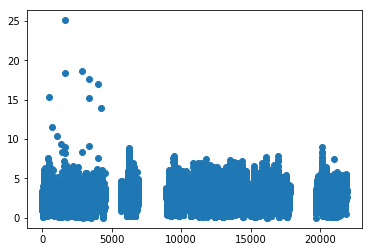

In [34]:
# same_intervals[3].plot()
plt.scatter(range(same_intervals[0].shape[0]), same_intervals[0])

In [ ]:
tmp_y = same_intervals[2].values

In [ ]:
tmp_y[np.isnan(tmp_y)] = 0

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler((0,1))

In [ ]:
y_scld = scaler.fit_transform(tmp_y.reshape(-1,1))

In [ ]:
plt.plot(y_scld)

## Wavelet

In [35]:
import pywt

In [36]:
coeff , freq = pywt.cwt(same_intervals[0], np.arange(1,60), 'gaus1')

In [38]:
len(same_intervals[0])

21888

In [37]:
coeff.shape

(59, 21888)

In [39]:
freq.shape

(59,)

In [40]:
freq

array([ 0.2       ,  0.1       ,  0.06666667,  0.05      ,  0.04      ,
        0.03333333,  0.02857143,  0.025     ,  0.02222222,  0.02      ,
        0.01818182,  0.01666667,  0.01538462,  0.01428571,  0.01333333,
        0.0125    ,  0.01176471,  0.01111111,  0.01052632,  0.01      ,
        0.00952381,  0.00909091,  0.00869565,  0.00833333,  0.008     ,
        0.00769231,  0.00740741,  0.00714286,  0.00689655,  0.00666667,
        0.00645161,  0.00625   ,  0.00606061,  0.00588235,  0.00571429,
        0.00555556,  0.00540541,  0.00526316,  0.00512821,  0.005     ,
        0.00487805,  0.0047619 ,  0.00465116,  0.00454545,  0.00444444,
        0.00434783,  0.00425532,  0.00416667,  0.00408163,  0.004     ,
        0.00392157,  0.00384615,  0.00377358,  0.0037037 ,  0.00363636,
        0.00357143,  0.00350877,  0.00344828,  0.00338983])

In [41]:
y = np.arange(0,coeff.shape[0])
x = np.arange(0,coeff.shape[1])
z = coeff

In [48]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

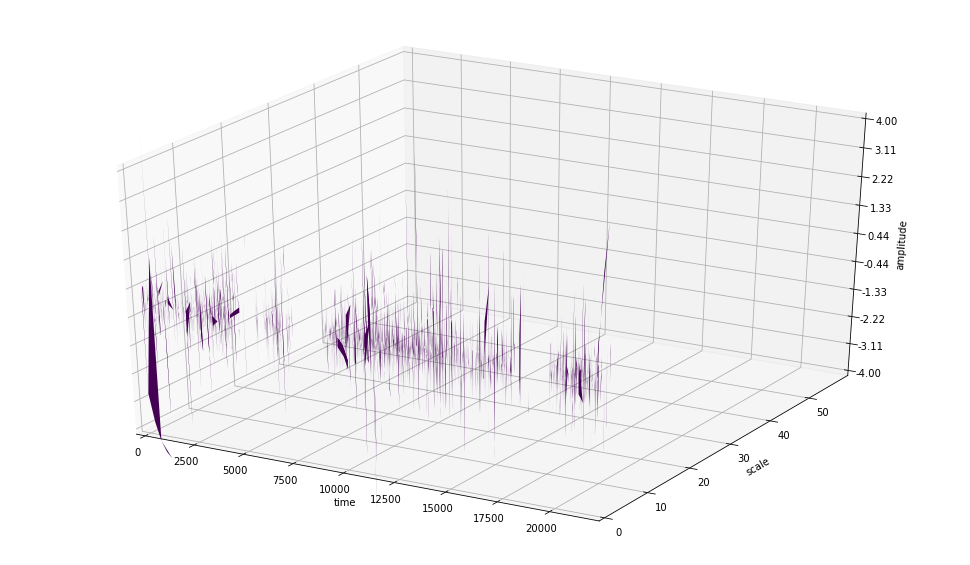

In [49]:
%matplotlib inline

# %matplotlib notebook
fig = plt.figure(figsize=(17,10))
ax = fig.gca(projection='3d')

rng = np.arange(1000,3000)
X, Y = np.meshgrid(x[rng], y)
Z = z[:,rng]

surf = ax.plot_surface(X,Y,Z, cmap='viridis',
                       linewidth=0)

# Customize the z axis.
ax.set_zlim(-4.001, 4.001)
ax.set_xlim(rng[0], rng[-1])
ax.set_ylim(0, 59)
ax.set_xlabel('time')
ax.set_ylabel('scale')
ax.set_zlabel('amplitude')
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

### KERAS AND LSTM

In [ ]:
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
np.random.seed(7)

In [ ]:
dataset = tmp_y.astype('float32')

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1,1))

In [ ]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

In [ ]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
%%time
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=2, batch_size=1, verbose=2)

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
dataset.shape

In [ ]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
trainPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

In [ ]:
# plot baseline and predictions
plt.figure(figsize=(15,9))
plt.title('Графики действительного и предсказанного c помощью LSTM значения inUtil')
plt.xlabel('time')
plt.ylabel('inUtil')
plt.plot(scaler.inverse_transform(dataset), label='Действительные значения')
plt.plot(trainPredictPlot, label='Предсказанные значения')
plt.legend()

In [ ]:
# plot baseline and predictions
plt.figure(figsize=(15,9))
plt.title('Увеличенный масштаб графиков действительного и предсказанного c помощью LSTM значения inUtil')
plt.xlabel('time')
plt.ylabel('inUtil')
plt.plot(scaler.inverse_transform(dataset)[:300], label='Действительные значения')
plt.plot(trainPredictPlot[:300], label='Предсказанные значения')
plt.legend()

In [ ]:
eps = [x-x1 for x,x1 in zip(scaler.inverse_transform(dataset),trainPredictPlot)]

In [ ]:
plt.figure(figsize=(15,9))
plt.plot(eps)

In [ ]:
eps = [x[0] for x in eps]

In [ ]:
eps[:5]

In [ ]:
d = pd.DataFrame()
d['x']=eps[1:]

In [ ]:
sns.kdeplot(eps[1:])

In [ ]:
# vals = ['cpu', 'mem', 'inn', 'out']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler([0,1])
vals = ['cpu', 'mem', 'inn', 'out']
mapping = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
X = pd.DataFrame()
X['date'] = same_intervals[0].index.values
for i, col in enumerate(same_intervals):
    X[vals[i]] = same_intervals[i].values
# X['month'] = X['date'].apply(lambda x: x.month)
# X['day'] = X['date'].apply(lambda x: x.month)
X['hour'] = X['date'].apply(lambda x: x.hour)
X['minute'] = X['date'].apply(lambda x: x.minute)
X['weekday'] = X['date'].apply(lambda x: x.weekday())
X['weekday'] = X['weekday'].map(mapping)
# X['is_first_half'] = X['date'].apply(lambda x: x.hour < 12).astype(bool)
X['is_busy_hour'] = X['date'].apply(lambda x: x.hour > 8 and x.hour < 19).astype(bool)

X.fillna(-1, inplace=True)

for i,val in enumerate(vals):
    X[val] = scaler.fit_transform(X[val].reshape(-1,1))
    
X.cpu = X.cpu.apply(lambda x: str(x) if x else 'empty').astype('object')
X.mem = X.mem.apply(lambda x: str(x) if x else 'empty').astype('object')

# for i in range(1, 13):
#     for val in vals:
#         col = '{}_lag{}'.format(val, i)
#         X[col] = X[val].shift(i)
#         if val in ['cpu', 'mem']:
#             X[col] = X[col].fillna('not seen')
#         else:
#             X[col].fillna(-2, inplace=True)
#             X[col] = scaler.fit_transform(X[col].reshape(-1,1))

    
date = X['date']
X.drop(['date'], axis=1, inplace=True)

In [ ]:
X.mem.unique()

### Попытка кластеризовать множество точек inn & out

In [ ]:
plt.scatter(X['inn'].values, X['out'].values)

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
inn_out_df = pd.DataFrame()

In [ ]:
inn_out_df['in'] = X['inn'].values
inn_out_df['out'] = X['out'].values

In [ ]:
clusterer = DBSCAN(p=2, eps=0.1, n_jobs=-1,min_samples=2, algorithm='kd_tree')

In [ ]:
y = clusterer.fit_predict(X = inn_out_df)

In [ ]:
set(clusterer.labels_)

In [ ]:
inn_out_df['y'] = y

In [ ]:
sns.lmplot(data=inn_out_df , x='in', y='out', hue='y', scatter=True, fit_reg=False)

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
manifolder = TSNE(n_components=2)

In [ ]:
# Xs = manifolder.fit_transform(inn_out_df[inn_out_df.columns[:-1]])

In [ ]:
Xs.shape

In [ ]:
plt.title("in and out after tsne")
plt.scatter(Xs[:,0], Xs[:,1])

In [ ]:
# ind = 100
# index = 200 #X.cpu.shape[0]
# color_mapping = [
#     (0.1, 0.2, 0.2, 0.3),
#     (0.5, 0.2, 0.1, 0.3),
#     (0.1, 0.9, 0.1, 0.3),
#     (0.2, 0.2, 0.9, 0.3),
# ]
# plt.figure(figsize=(17,9))
# plt.grid(True)
# for i, val in enumerate(vals):
#     print(val)
#     plt.scatter(X.index.values[ind:index], X[val].values[ind:index], label=val, c=color_mapping[i])
# plt.legend()

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, RandomizedSearchCV

In [ ]:
from xgboost import plot_importance, XGBClassifier, XGBRegressor, XGBModel

In [ ]:
df = X.copy(deep=True)

In [ ]:
col = 'inn'
Y = df[col]
train_X = df.drop([col], axis=1)

In [ ]:
train_X = pd.get_dummies(data=train_X, columns=train_X.select_dtypes(include='object'))

In [ ]:
train_X.head()

In [ ]:
cv = TimeSeriesSplit(n_splits=7)

In [ ]:
# scale_pos_weight = sum(negative_cases)/sum(positive cases)

In [ ]:
# A parameter grid for XGBoost
params = {
    'n_estimators': np.arange(40, 110, 10),
    'min_child_weight':[4,5], 
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4]
}

# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=-1)#XGBClassifier(nthread=-1) #XGBRegressor(n_estimators=80)

grid = RandomizedSearchCV(xgb, params, cv=cv, scoring='neg_median_absolute_error')

In [ ]:
from sklearn.metrics import precision_score

In [ ]:
grid.fit(train_X, Y)

In [ ]:
a = cross_val_score(grid, train_X, Y, cv=cv)

In [ ]:
a

In [ ]:
a.mean()

In [ ]:
plt.figure(figsize=(19,7))
plt.title('Графики действительного и предсказанного с помошбю бустинга значения inUtil')
plt.xlabel('time')
plt.ylabel('inUtil')
plt.plot(Y[:])
plt.plot(grid.predict(train_X)[:])

In [ ]:
plt.figure(figsize=(19,7))
plt.title('Увеличенный масштаб графиков действительного и предсказанного с помошбю бустинга значения inUtil')
plt.xlabel('time')
plt.ylabel('inUtil')
plt.plot(Y[:300].values)
plt.plot(grid.predict(train_X)[:300])

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(Y-grid.predict(train_X))

#### adfuller

In [ ]:
import pyspc

In [ ]:
dir(pyspc)

In [ ]:
pyspc.spc(train_X['out'].values)

In [ ]:
import statsmodels.tsa as tsa

In [ ]:
train_X['out'].shape

In [ ]:
tsa.stattools.acf(train_X['out'].values)

In [ ]:
aa = tsa.filters.bk_filter.bkfilter(train_X['out'],12)

In [ ]:
cf_cycles, cf_trend = tsa.filters.cf_filter.cffilter(train_X['out'])

In [ ]:
plt.plot(bb);

In [ ]:
plt.plot(aa)

In [ ]:
import changefinder

In [ ]:
changefinder.sm.GLS(train_X['out'])

# Анализ работы различных моделей

Для начала определимся с тем, какой тип задачи будем решать.

1. Обучение без учителя
2. Обучение с учителем

! Замечания по первому пункту

    Посмотреть следующие статьи
        https://www.sciencedirect.com/science/article/pii/S0377042707001100
        какой-то алгоритм с HTM https://www.sciencedirect.com/science/article/pii/S0925231217309864
        https://pdfs.semanticscholar.org/bffb/4986040684253b6f5a6e918602a027ae9668.pdf
        может что здесь будет интересно https://www.jstor.org/stable/2290724?seq=1#page_scan_tab_contents
        H-S-ESD https://blog.twitter.com/engineering/en_us/a/2015/introducing-practical-and-robust-anomaly-detection-in-a-time-series.html
        

    Точечные аномалии
        -1 Еще можно такой вариант. Берется окно(пусть в день) высчитывается робастаная( медианы) средняя и std. Затем находим z-score. Если z-score больше заданного порога(вот тут загвоздочка. Мб функционал задать и 
        0. Метод отсюда  pandas.stats.moments.ewma 
        1. Средлнее отклонение
        1. Доверительный интервал
        2. Значения выходящее за 3sigma
        3. ESD
        4. GenerilizedESD
        5. H-S-ESD (twitter)
        6. Prophet попробовать
        7. Wavelet для определения сезонности
        8. Kalman Filter
           метод отсюда https://pdfs.semanticscholar.org/bffb/4986040684253b6f5a6e918602a027ae9668.pdf
        9. STL
        10. Потыкать pyspc
        11. Рассматривать scatter и строить линейную аппроксимацию. Значения, которые отклоняются на заданный интервал будут аномалиями
    
    Аномалии по окнам
    

! Замечания по второму пункту

Для второго пункта нужны размеченные данные. Это сделаем просто. Бутстрепом определим доверительный интервал для каждого временного ряда (среднее +- отклонение)

### EWMA

In [ ]:
inn_out_df.columns

In [ ]:
import pandas, numpy as np
ewma = pandas.stats.moments.ewma

i = 600
x = X['inn'].values
ixs = x>0
x = x[ixs]
print(x.shape)
t = date.index.values
t = t[ixs]

# take EWMA in both directions with a smaller span term
fwd = ewma( x, span=6)          # take EWMA in fwd direction
bwd = ewma( x[::-1], span=6)    # take EWMA in bwd direction
c = np.vstack((fwd, bwd[::-1] )) # lump fwd and bwd together
c = np.mean( c, axis=0 )          # average  
print(c.shape)

plt.figure(figsize=(19,8))
plt.title('Графики действительного и предсказанного с помошбю бустинга значения inUtil')
plt.xlabel('time')
plt.ylabel('inUtil')
plt.scatter( range(len(x)), x,  alpha=0.4, label='inUtil' )
plt.plot( ewma( x, span=6), 'g', label='EWMA, span=6')
plt.plot( c, 'r', label='Reversed-Recombined' )
plt.legend()

plt.figure(figsize=(19,8))
plt.title('Увеличенный масштаб графиков действительного и предсказанного с помошбю бустинга значения inUtil')
plt.xlabel('time')
plt.ylabel('inUtil')
plt.scatter( range(len(x[:300])), x[:300],  alpha=0.4, label='inUtil' )
plt.plot( ewma( x[:300], span=6), 'g', label='EWMA, span=6')
plt.plot( c[:300], 'r', label='Reversed-Recombined' )
plt.legend()

### Среднее отклонение. Че-то я пока не могу понять, в чем суть этого метода

In [ ]:
in_mean = X.loc[X['inn'] > 0, 'inn'].mean()

In [ ]:
in_mean

In [ ]:
plt.scatter(date.index.values, X['inn'].values)
plt.axhline(in_mean, c='r')

In [ ]:
plt.scatter(date.index.values, X['inn'].values-in_mean)

### Пример для бутстрепа. Правило трех сигм

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Create toy data 
x = date.index.values
y = X['inn'].values

# Extend x data to contain another row vector of 1s
Xx = np.vstack([x, np.ones(x.shape[0])]).T


# plt.figure(figsize=(12,8))
means = []
for i in range(1000):
    sample_index = np.random.choice(range(0, y.shape[0]), y.shape[0])

    X_samples = x[sample_index]
    y_samples = y[sample_index]  
    
    means.append(y_samples.mean())

In [ ]:
import numpy as np, scipy.stats as st
interval = st.t.interval(0.95, len(means)-1, loc=np.mean(means), scale=st.sem(means))

In [ ]:
std = np.asarray(means).std()

In [ ]:
mean = np.asarray(means).mean()

In [ ]:
mean = X.loc[X['inn']>0, 'inn'].mean()

In [ ]:
std = X.loc[X['inn']>0, 'inn'].std()

In [ ]:
mean

In [ ]:
std

In [ ]:
mark = np.asarray([0 if x > mean-3*std and x < mean+3*std else 1 for x in X['inn'].values])

In [ ]:
plt.scatter(date.index, X['inn'].values)
plt.axhline(mean)
plt.axhline(mean+3*std)
plt.axhline(mean-3*std)

In [ ]:
xx = pd.DataFrame()
xx['index'] = date.index.values
xx['inn'] = X['inn'].values
xx['mark'] = mark

In [ ]:
xx['prediction'] = xx['mark'].map({1:'bad', 0:'good'})

In [ ]:
sns.lmplot(data=xx, x='index', y='inn', hue='prediction',scatter=True, fit_reg=False,size=8, aspect=2)
# plt.axhline(mean)
plt.axhline(mean+3*std, linestyle='--')
plt.title('Метод 3 сигм')
plt.ylabel('inUtil')
plt.xlabel('time')

### ESD

### generilizedESD

In [ ]:
from PyAstronomy import pyasl

In [ ]:
outliers = pyasl.generalizedESD(X['inn'].values, 40,alpha=0.05, fullOutput=True)[1]

In [ ]:
outliers

In [ ]:
r = pd.DataFrame()
r['inn'] = X['inn'].values
r['prediction'] = 0
r['index'] = X['inn'].index.values
r.loc[r['prediction'].apply(lambda x: x in outliers), 'prediction'] = 1

In [ ]:
for i in outliers:
    r.iloc[i]['prediction'] = 1

In [ ]:
r.prediction.unique()

In [ ]:
sns.lmplot(data=r, x='index', y='inn', hue='prediction', scatter=True, fit_reg=False)

In [ ]:
plt.figure(figsize=(17,9))
plt.title('Generilized ESD')
plt.ylabel('inUtil')
plt.xlabel('time')
plt.scatter(date.index.values, X['inn'].values, label='good')
plt.scatter(date.index.values[outliers], X['inn'].values[outliers], c='r', label='bad')
plt.legend()

### H-S-ESD

In [ ]:
from pyculiarity import detect_ts

In [ ]:
test = pd.DataFrame()
test['timestamp'] = date.index.values
test['count'] = X['inn'].values
results = detect_ts(test, max_anoms=0.05, alpha=0.001, direction='both')

In [ ]:
results['anoms']['anoms'].index.values[:5]

In [ ]:
ixs = test.loc[test['timestamp'].isin(results['anoms'].index.values),'timestamp']

In [ ]:
ixs.index[:5]

In [ ]:
plt.figure(figsize=(17,9))
plt.title('S-H-ESD')
plt.ylabel('inUtil')
plt.xlabel('time')
plt.scatter(test['timestamp'].index, test['count'], label='good')
plt.scatter(test['timestamp'].index.values[ixs.index], results['anoms']['anoms'].values, color='r', label='bad')
plt.legend()

### Prophet

In [ ]:
from fbprophet import Prophet

In [ ]:
df = pd.DataFrame()
df['ds'] = date.values
df['y'] = X['inn'].values

In [ ]:
m = Prophet(yearly_seasonality=False)
m.fit(df)

In [ ]:
interpolate = m.predict(df)

In [ ]:
# interpolate.head()

In [ ]:
m.plot?

In [ ]:
plt.plot(interpolate.yhat)

In [ ]:
interpolate.head()

In [ ]:
plt.plot(interpolate.yhat)

In [ ]:
# plt.rcParams['figure.figsize']=(19,7)
m.plot(interpolate,xlabel='time', ylabel='inUtil', plot_cap=.5)
plt.title('ff')

### STL

In [ ]:
import stldecompose

In [ ]:
res = stldecompose.decompose(X['inn'].values)

In [ ]:
x = date.index.values
plt.plot(x, res.observed)
plt.plot(x, res.resid)
# plt.plot(x, res.observed-res.seasonal-res.trend)

In [ ]:
# plt.plot(date.index[:500], res.seasonal[:500])
# plt.xticks(date.index[:500], date.values[:500], rotation=90);

In [ ]:
date.min()

In [ ]:
date.max()

In [ ]:
plt.plot(date.index, res.trend)

### Обучение с учителем.

Для начала быстро и просто разметим данные. Пусть аномалия - отклонение на 3 сигмы от среднего

In [ ]:
X.cpu.unique()

In [ ]:
def data_for_outlier_datection(X, col):
    df = pd.DataFrame()
    df['date'] = date.values
    df['val'] = X[col].values
    mean = df.loc[df['val'] > 0, 'val'].mean()
    std = df.loc[df['val'] > 0, 'val'].std()
    df['outlier'] = df['val'].apply(lambda x: 0 if (x < mean + 3*std and x > mean - 3* std) or x == 0 else 1)
    df['index'] = df.index.values
    return df, mean, std

In [ ]:
df_inn, mi, si = data_for_outlier_datection(X, 'inn')
df_out, ms, ss = data_for_outlier_datection(X, 'out')

In [ ]:
sns.lmplot(data=df_inn, x='index', y='val', hue='outlier', scatter=True, fit_reg=False)
plt.axhline(mi)
plt.axhline(mi-3*si)
plt.axhline(mi+3*si)

In [ ]:
sns.lmplot(data=df_out, x='index', y='val', hue='outlier', scatter=True, fit_reg=False)
plt.axhline(ms)
plt.axhline(ms-3*ss)
plt.axhline(ms+3*ss)

## Классификация

In [ ]:
X.head()

In [ ]:
d = X.copy(deep=True)

In [ ]:
scaler = MinMaxScaler((0,1))

In [ ]:
d['inn'] = scaler.fit_transform(d['inn'].reshape(-1,1))
d['out'] = scaler.fit_transform(d['out'].reshape(-1,1))
d['hour'] = scaler.fit_transform(d['hour'].reshape(-1,1))
d['minute'] = scaler.fit_transform(d['minute'].reshape(-1,1))

In [ ]:
ixs1 = df_out.loc[df_out['outlier'] == 1, 'date']
ixs2 = df_inn.loc[df_inn['outlier'] == 1, 'date']

In [ ]:
data = d.copy(deep=True)

In [ ]:
data['outlier'] = -1
data.loc[data.index.isin(list(set(ixs1.index.values) | set(ixs2.index.values))), 'outlier'] = 1

In [ ]:
data['outlier'].unique()

In [ ]:
data['outlier'].value_counts()

In [ ]:
y = data['outlier']
data.drop('outlier', axis=1, inplace=True)

In [ ]:
data1 = pd.get_dummies(data)

In [ ]:
data1.head()

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, RandomizedSearchCV, KFold

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, precision_recall_curve, roc_auc_score

In [ ]:
cv = TimeSeriesSplit(n_splits=7)

In [ ]:
cv = KFold(n_splits=7,  shuffle=True)

#### IsolationForest

In [ ]:
clf = IsolationForest(bootstrap=True, n_estimators=100, random_state=7, contamination=0.0001, n_jobs=-1)

In [ ]:
mask = data1['inn']>0

In [ ]:
dd = data1[mask].reset_index(drop=True)
y1 = y[mask]

In [ ]:
dd.head()

In [ ]:
set(y1)

In [ ]:
for train_index, test_index  in cv.split(dd):
    train_x, train_y = dd.iloc[train_index], y[train_index]
    test_x, test_y = dd.iloc[test_index], y[test_index]
    clf.fit(train_x, train_y)
    y_pred = clf.predict(test_x)
    print(roc_auc_score(test_y, -clf.decision_function(test_x)))
    print(roc_auc_score(test_y, clf.predict(test_x)))
#     print(set(test_y))
#     print(set(y_pred))
#     try:
#         acc = accuracy_score(y_pred=y_pred, y_true=test_y)
#         prec = precision_score(y_pred=y_pred, y_true=test_y)
#         auc = roc_auc_score(y_score=y_pred, y_true=test_y)
#         print(acc)
#         print(prec)
#         print(auc)
#         print()
#     except:
#         print('oops')
    
#     X_

In [ ]:
print(roc_auc_score(y, -clf.decision_function(data1)))

In [ ]:
y_pred = -clf.decision_function(data1)

In [ ]:
d = pd.DataFrame()
d['true'] = y.values
d['pred'] = [1 if i>0 else -1 for i in y_pred]

In [ ]:
test_df = pd.DataFrame()
test_df['in'] = data1['inn'].values
test_df['pred'] = d['pred'].values
test_df['index'] = d.index.values


In [ ]:
sns.lmplot(data=test_df, x='index', y='in', hue='pred')

In [ ]:
d[['pred','true']].head()

#### OneClassSVM

In [ ]:
clf = OneClassSVM(nu=sum(y==1)/sum(y==-1), kernel="rbf", gamma=0.001)

In [ ]:
for train_index, test_index  in cv.split(dd):
    train_x, train_y = dd.iloc[train_index], y1.iloc[train_index]
    test_x, test_y = dd.iloc[test_index], y1.iloc[test_index]
    print(set(test_y))
    clf.fit(train_x, train_y)
    y_pred = clf.predict(test_x)
    print(roc_auc_score(y_score=y_pred, y_true=test_y))

In [ ]:
clf.fit(data1, y)
y_pred = clf.predict(data1)

d = pd.DataFrame()
d['true'] = y.values
d['pred'] = y_pred

In [ ]:
d = pd.DataFrame()
d['true'] = y.values
d['pred'] = [1 if i>0 else -1 for i in y_pred]
test_df = pd.DataFrame()
test_df['in'] = data1['inn'].values
test_df['pred'] = d['pred'].values
test_df['index'] = d.index.values
sns.lmplot(data=test_df, x='index', y='in', hue='pred', size=8, aspect=2, fit_reg=False)
plt.title('SVM для поиска аномалий')
plt.xlabel('time')
plt.ylabel('inUtil')

#### LocalOutlierFactor

In [ ]:
y1.value_counts()

In [ ]:
clf = LocalOutlierFactor(n_neighbors=35, contamination=0.01)

In [ ]:
y_pred = clf.fit_predict(data1[y==1], y[y==1])


In [ ]:
d.corr()

In [ ]:
d = pd.DataFrame()
d['true'] = y.values
d['pred'] = [1 if i>0 else -1 for i in y_pred]
test_df = pd.DataFrame()
test_df['in'] = data1['inn'].values
test_df['pred'] = d['pred'].values
test_df['index'] = d.index.values
sns.lmplot(data=test_df, x='index', y='in', hue='pred', size=8, aspect=2)
plt.title('SVM для поиска аномалий')
plt.xlabel('time')
plt.ylabel('inUtil')